In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.io import arff
import pickle
from sklearn.utils import shuffle

In [2]:
loaded = arff.loadarff('../connect-4.arff')

data = np.asarray(loaded[0].tolist(), dtype=np.float32)
X = data[:, :-1]
y = data[:, -1]

# extract the classes
X_zeros = X[y == 0]
y_zeros = y[y == 0]
X_ones = X[y == 1]
y_ones = y[y == 1]
X_twos = X[y == 2]
y_twos = y[y == 2]

max_from_each_class = min(X_zeros.shape[0], X_ones.shape[0], X_twos.shape[0])
print("max_from_each_class:", max_from_each_class)

# shuffle
np.random.seed(10)
X_zeros, y_zeros = shuffle(X_zeros, y_zeros)
X_ones, y_ones = shuffle(X_ones, y_ones)
X_twos, y_twos = shuffle(X_twos, y_twos)

# take only the first max_from_each_class elements
X_zeros = X_zeros[:max_from_each_class]
y_zeros = y_zeros[:max_from_each_class]
X_ones = X_ones[:max_from_each_class]
y_ones = y_ones[:max_from_each_class]
X_twos = X_twos[:max_from_each_class]
y_twos = y_twos[:max_from_each_class]

# split into train, test, and validation
X_zeros_train, X_zeros_testval, y_zeros_train, y_zeros_testval = train_test_split(X_zeros, y_zeros, test_size=0.2)
X_ones_train, X_ones_testval, y_ones_train, y_ones_testval = train_test_split(X_ones, y_ones, test_size=0.2)
X_twos_train, X_twos_testval, y_twos_train, y_twos_testval = train_test_split(X_twos, y_twos, test_size=0.2)
X_zeros_test, X_zeros_val, y_zeros_test, y_zeros_val = train_test_split(X_zeros_testval, y_zeros_testval, test_size=0.5)
X_ones_test, X_ones_val, y_ones_test, y_ones_val = train_test_split(X_ones_testval, y_ones_testval, test_size=0.5)
X_twos_test, X_twos_val, y_twos_test, y_twos_val = train_test_split(X_twos_testval, y_twos_testval, test_size=0.5)

# concatenate
X_train = np.concatenate((X_zeros_train[:max_from_each_class], X_ones_train[:max_from_each_class], X_twos_train[:max_from_each_class]), axis=0)
y_train = np.concatenate((y_zeros_train[:max_from_each_class], y_ones_train[:max_from_each_class], y_twos_train[:max_from_each_class]), axis=0)
X_test = np.concatenate((X_zeros_test[:max_from_each_class], X_ones_test[:max_from_each_class], X_twos_test[:max_from_each_class]), axis=0)
y_test = np.concatenate((y_zeros_test[:max_from_each_class], y_ones_test[:max_from_each_class], y_twos_test[:max_from_each_class]), axis=0)
X_val = np.concatenate((X_zeros_val[:max_from_each_class], X_ones_val[:max_from_each_class], X_twos_val[:max_from_each_class]), axis=0)
y_val = np.concatenate((y_zeros_val[:max_from_each_class], y_ones_val[:max_from_each_class], y_twos_val[:max_from_each_class]), axis=0)

# convert 2s to -1s
X_train[X_train == 2] = -1
X_test[X_test == 2] = -1
X_val[X_val == 2] = -1

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)

max_from_each_class: 6449
X_train: (15477, 42)
y_train: (15477,)
X_test: (1935, 42)
y_test: (1935,)
X_val: (1935, 42)
y_val: (1935,)


#### The SVM objective function: 
$\min \lambda/2 \lVert {\bf w}\rVert_2^2 + \sum_{i=1}^N\max(0,1-y^{(i)}({\bf w}^T{\bf x}^{(i)}+w_0)$ where $w_0=0$.

In [3]:
def svm_objective(w, X, y, lambda1=.1):
    result = 0.5 * lambda1 * np.dot(w, w.T) + np.sum(np.maximum(0, 1 - y * np.dot(X, w)))
    return result * 1.0 / X.shape[0]

In [4]:
def pegasos(X_train, y_train, X_test, y_test_encoded, lambda1=0.08, num_iters = 3, threshold = 0.5):
    N = X_train.shape[0]
    d = X_train.shape[1]

    t = 0
    w = np.ones((d,))
    training_scores = []
    test_scores = []
    test_accuracys = []

    np.random.seed(10)
    randoms = np.random.randint(0, N, size=(num_iters, N))
    for iter in range(num_iters):
        training_scores.append(svm_objective(w, X_train, y_train, lambda1))
        test_scores.append(svm_objective(w, X_test, y_test, lambda1))

        y_test_pred = np.where(np.dot(X_test, w) >= threshold, 1, -1)
        test_accuracys.append(np.sum(y_test_pred == y_test_encoded) / len(y_test_encoded))

        for i in range (N):
            r = randoms[iter][i]
            t = t + 1
            alpha = 1/(lambda1*t)
            if (y_train[r] * np.dot(w, X_train[r]) >= 1):
                w = w - alpha * lambda1 * w
            else:
                w = w - alpha * (lambda1 * w - (y_train[r] * X_train[r]))
        
    return w, training_scores, test_scores, test_accuracys

In [5]:
class Model:
    def __init__(self, lam, threshold, poly_degree):
        self.final_weights = None
        self.training_scores_over_time = None
        self.test_scores_over_time = None
        self.final_accuracy_per_class = None
        self.final_overall_accuracy = None

        self.lam = lam
        self.threshold = threshold
        self.poly_degree = poly_degree
        self.poly = None
    
    def copy(self):
        return Model(self.lam, self.threshold, self.poly_degree)
    
    def train(self, X_train, y_train, X_test, y_test, iters):
        self.final_weights = {}
        self.training_scores_over_time = {}
        self.test_scores_over_time = {}
        self.test_accuracy_over_time = {}
        self.final_accuracy_per_class = {}

        poly = preprocessing.PolynomialFeatures(self.poly_degree)
        X_train = poly.fit_transform(X_train)
        X_test = poly.transform(X_test)
        self.poly = poly

        for i in range(3):
            print("Training model for class", i)
            y_encoded = np.where(y_train == i, 1, -1)
            y_test_encoded = np.where(y_test == i, 1, -1)
            self.final_weights[i], self.training_scores_over_time[i], self.test_scores_over_time[i], self.test_accuracy_over_time[i] = pegasos(X_train, y_encoded, X_test, y_test_encoded, self.lam, iters, self.threshold)

            y_test_pred = np.where(np.dot(X_test, self.final_weights[i]) >= self.threshold, 1, -1)
            self.final_accuracy_per_class[i] = np.sum(y_test_pred == y_test_encoded) / len(y_test_encoded)
            print()
        
        w = np.vstack((self.final_weights[0], self.final_weights[1], self.final_weights[2])).T
        scores = np.dot(X_test, w)
        guesses = np.argmax(scores, axis=1)
        self.final_overall_accuracy = (guesses == y_test).sum()/len(y_val)
    
    def show_results(self, training_name="Training", test_name="Test"):
        # Print hyperparameters
        print("Hyperparameters: lam=%.3f, threshold=%.3f, poly_degree=%d" % (self.lam, self.threshold, self.poly_degree))
        print("Final overall accuracy:", self.final_overall_accuracy)
        # For each class, plot the training and test scores over time. Ensure training and test are plotted in the same graph just different label
        # Next to each of these, plot the accuracy of the model on the test set for each class.
        # Make all plots in one figure. Show precise value for first and last iteration

        # remove first iteration from scores
        for i in range(3):
            self.test_scores_over_time[i] = self.test_scores_over_time[i][1:]
            self.training_scores_over_time[i] = self.training_scores_over_time[i][1:]
            self.test_accuracy_over_time[i] = self.test_accuracy_over_time[i][1:]

        fig, axs = plt.subplots(3, 2, figsize=(15, 15))
        for i in range(3):
            axs[i][0].plot(self.test_scores_over_time[i], label=test_name)
            axs[i][0].plot(self.training_scores_over_time[i], label=training_name)
            axs[i][0].set_title("Scores - Class %d" % i)
            axs[i][0].set_xlabel("Iteration")
            axs[i][0].set_ylabel("Objective")
            axs[i][0].legend()
            axs[i][1].plot(self.test_accuracy_over_time[i])
            axs[i][1].set_xlabel("Iteration")
            axs[i][1].set_ylabel("Accuracy")
            axs[i][1].set_title("Accuracy - Class %d" % i)
            
            # Show precise value for first and last iteration
            axs[i][0].text(0, self.test_scores_over_time[i][0], "%.3f" % self.test_scores_over_time[i][0])
            axs[i][0].text(0, self.training_scores_over_time[i][0], "%.3f" % self.training_scores_over_time[i][0])
            axs[i][0].text(len(self.test_scores_over_time[i]) - 1, self.test_scores_over_time[i][-1], "%.3f" % self.test_scores_over_time[i][-1])
            axs[i][0].text(len(self.training_scores_over_time[i]) - 1, self.training_scores_over_time[i][-1], "%.3f" % self.training_scores_over_time[i][-1])
            axs[i][1].text(0, self.test_accuracy_over_time[i][0], "%.3f" % self.test_accuracy_over_time[i][0])
            axs[i][1].text(len(self.test_accuracy_over_time[i]) - 1, self.test_accuracy_over_time[i][-1], "%.3f" % self.test_accuracy_over_time[i][-1])
        
        plt.show()    

Number of variations: 1

Training model 1/1
Training model for class 0

Training model for class 1

Training model for class 2

Best model:
Hyperparameters: lam=0.001, threshold=0.500, poly_degree=2
Final overall accuracy: 0.6578811369509044


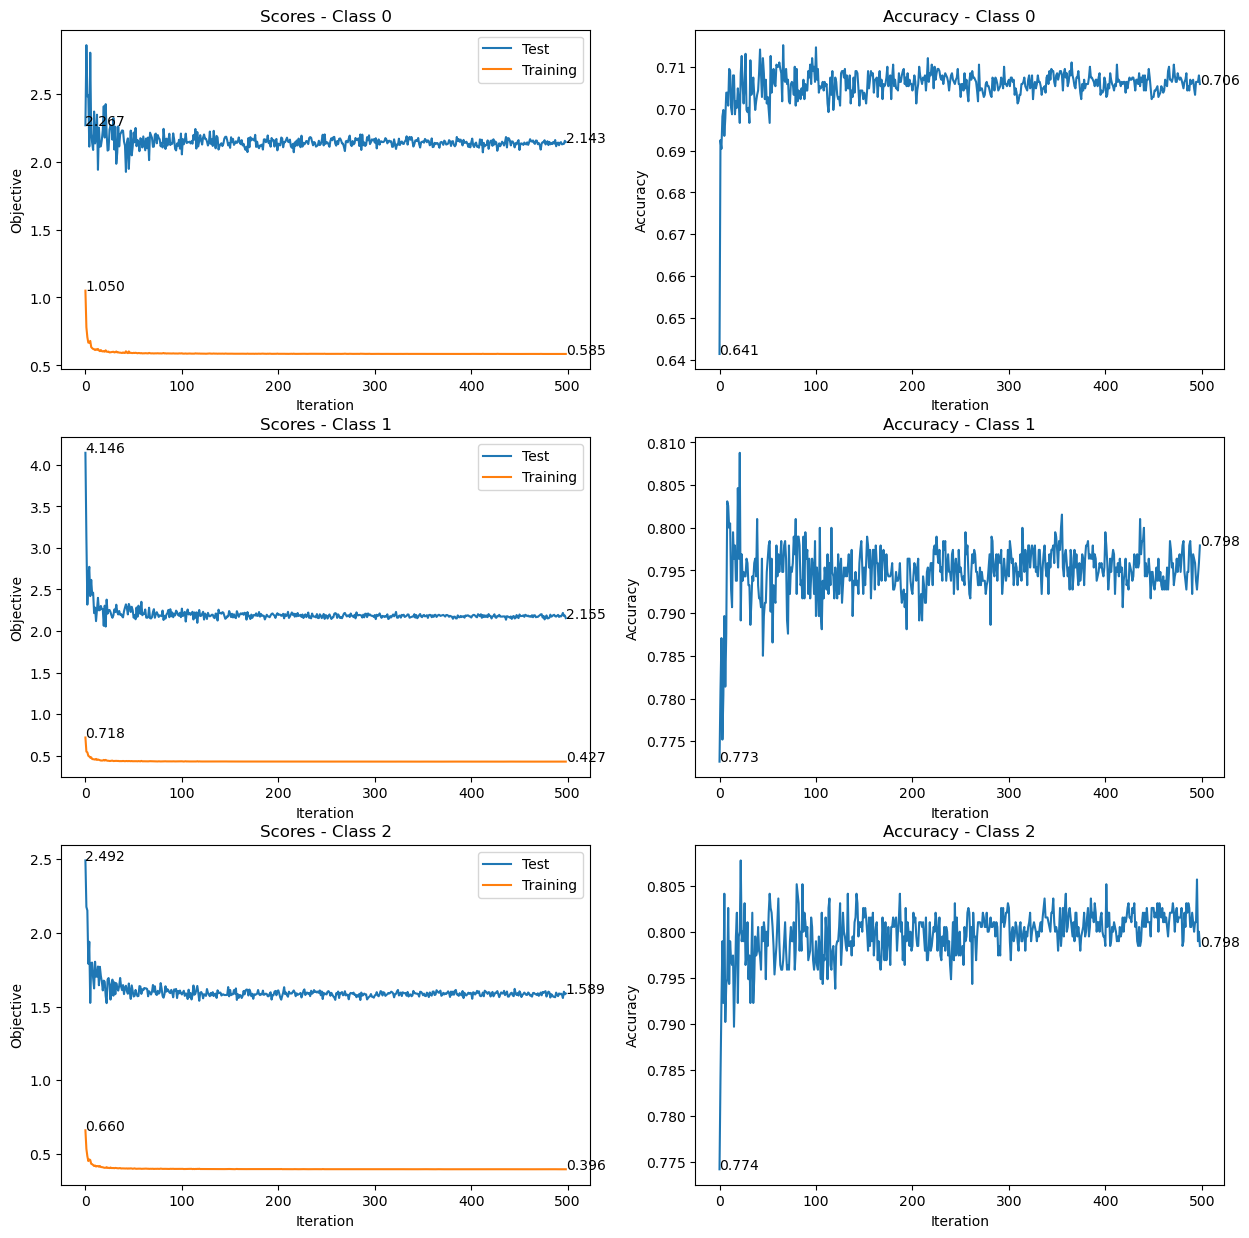

In [6]:
lambdas = [0.001]
thresholds = [0.5]
poly_degrees = [2]

# combine x_train and x_val
X_train = np.vstack((X_train, X_val))
y_train = np.hstack((y_train, y_val))

print("Number of variations:", len(lambdas) * len(thresholds) * len(poly_degrees))
print()

models = []
for poly_degree in poly_degrees:
    for threshold in thresholds:
        for lam in lambdas:
            models.append(Model(lam, threshold, poly_degree))

for i, model in enumerate(models):
    print("Training model %d/%d" % (i + 1, len(models)))
    model.train(X_train, y_train, X_test, y_test, 500)

# Find best model
best_model = None
best_accuracy = 0
for model in models:
    if model.final_overall_accuracy > best_accuracy:
        best_accuracy = model.final_overall_accuracy
        best_model = model

print("Best model:")
best_model.show_results()

In [7]:
for m in models:
    print("Model with lam=%.3f, threshold=%.3f, poly_degree=%d: Accuracy was %.3f" % (m.lam, m.threshold, m.poly_degree, m.final_overall_accuracy))

has_transformed = False

Model with lam=0.001, threshold=0.500, poly_degree=2: Accuracy was 0.658


[1 0 2 ... 2 2 1]
              precision    recall  f1-score   support

           0       0.57      0.57      0.57       645
           1       0.69      0.69      0.69       645
           2       0.71      0.71      0.71       645

    accuracy                           0.66      1935
   macro avg       0.66      0.66      0.66      1935
weighted avg       0.66      0.66      0.66      1935



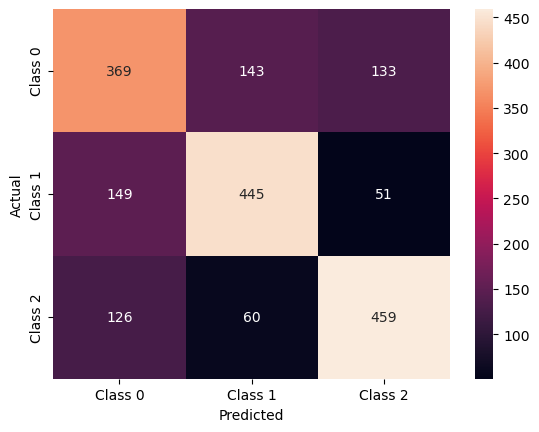

In [8]:
# Make a confusion matrix based on the test data and the best model
import seaborn as sns

# transform X_test with best model poly and convert y_test to int
if not has_transformed:
    X_test = best_model.poly.transform(X_test)
    y_test = y_test.astype(int)
    has_transformed = True

y_test_pred = np.argmax(np.dot(X_test, np.vstack((best_model.final_weights[0], best_model.final_weights[1], best_model.final_weights[2])).T), axis=1)
print(y_test_pred)

from sklearn.metrics import classification_report

# Print the classification report
print(classification_report(y_test, y_test_pred))

confusion_matrix = np.zeros((3, 3))
for i in range(len(y_test)):
    confusion_matrix[y_test[i]][y_test_pred[i]] += 1

classes = ["Class 0", "Class 1", "Class 2"]
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()